In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')

import torch as th
from torch import autograd as tha
from torch.utils import data


From expert_rollouts/Hopper-v1/n20_1.pkl
Loaded observations: (20000, 11)
Loaded actions: (20000, 3)


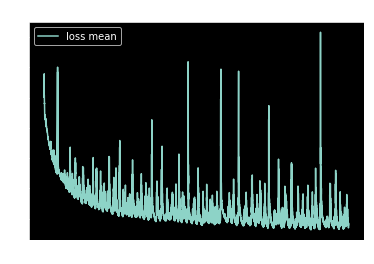

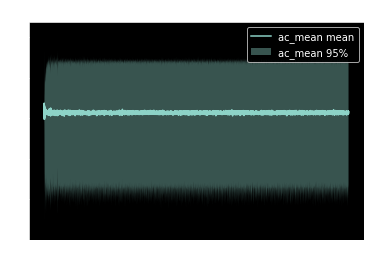

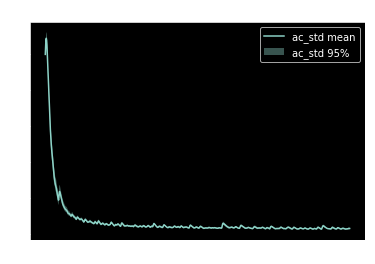

In [165]:
# Section 2: Warmup Behavior Cloning.

import math
import os
import pickle

from rl.algs import plotter
from rl.algs.pg import Environment

dtype = th.cuda.FloatTensor

os.chdir('/home/z/code/blaze_root/src/rl/berkeleyrlcourse/hw1')

class Model(th.nn.Module):
  def __init__(self, obs_dim, action_dim, model_std, min_std=None,
               hidden_dim=64, depth=6):
    super().__init__()
    self.min_logstd = math.log(min_std) if min_std else None
    modules = [
      th.nn.Linear(obs_dim, hidden_dim),
      th.nn.ReLU(),
    ]
    for _ in range(depth - 3):
      modules.append(th.nn.Linear(hidden_dim, hidden_dim))
      modules.append(th.nn.ReLU())
    self.base_nn = th.nn.Sequential(*modules)
    self.means = th.nn.Sequential(
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, action_dim),
    )
    if model_std:
      self.logstds = th.nn.Sequential(
        th.nn.Linear(hidden_dim, hidden_dim),
        th.nn.ReLU(),
        th.nn.Linear(hidden_dim, hidden_dim),
        th.nn.ReLU(),
        th.nn.Linear(hidden_dim, action_dim)
      )
    else:
      self._logstds = th.nn.Parameter(th.zeros((1, action_dim)).type(dtype))
      self.logstds = lambda _: self._logstds

  def forward(self, x):
    x = self.base_nn(x)
    logstds = self.logstds(x)
    if self.min_logstd is not None:
      logstds = th.clamp(logstds, min=self.min_logstd)
    return self.means(x), logstds

class ImitationPolicy(object):
  """Continuous action policy, trained on imitation."""
  def __init__(self, expert_dataset, model, lr=0.001):
    self.model = model
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
 
  def get_action(self, obs_np):
    obs_var = tha.Variable(th.from_numpy(obs_np).type(dtype))
    dist = self._get_action_distribution(obs_var)
    ac = dist.sample()
    out_np = ac.data.cpu().numpy()
    return out_np
  
  def _get_action_distribution(self, obs_var):
    means, logstds = self.model(obs_var)
    stds = th.exp(logstds)
    dist = th.distributions.Normal(means, stds)
    return dist

  def step(self, obs_batch, acs_batch):
    metrics = {}
    obs_var = tha.Variable(obs_batch.type(dtype))
    acs_var = tha.Variable(acs_batch.type(dtype))
    dist = self._get_action_distribution(obs_var)
    log_probs = dist.log_prob(acs_var)
    loss = -log_probs.mean()
    
    metrics['loss'] = loss.data.cpu().numpy()[0]
    metrics['ac_mean'] = dist.mean.data.cpu().numpy()
    metrics['ac_std'] = dist.std.data.cpu().numpy()
    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
 
    return metrics

class ExpertDataset(object):
  def __init__(self, pkl_file, batch_size):
    with open(pkl_file, 'rb') as fd:
      rollouts = pickle.load(fd)
    self.obs = rollouts['observations']
    self.acs = rollouts['actions']
    
    print(f'From {pkl_file}')
    print(f'Loaded observations: {self.obs.shape}')
    print(f'Loaded actions: {self.acs.shape}')
    
    obs_tensor = th.from_numpy(self.obs).cuda()
    acs_tensor = th.from_numpy(self.acs).cuda()
    
    dataset = data.TensorDataset(obs_tensor, acs_tensor)
    self.data_loader = data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    
  @property
  def obs_dim(self):
    return self.obs.shape[-1]
  
  @property
  def acs_dim(self):
    return self.acs.shape[-1]
    
  def __iter__(self):
    self.iter = iter(self.data_loader)
    return self
  
  def __next__(self):
    try:
      return next(self.iter)
    except StopIteration:
      self.iter = iter(self.data_loader)
      return next(self.iter)


NUM_STEPS = 10000
MINI_BATCH_SIZE = 400
plt = plotter.Plotter()

ENV_NAME = 'Hopper-v1'
#ENV_NAME = 'Humanoid-v1'
pkl_file = f'expert_rollouts/{ENV_NAME}/n20_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
model = Model(expert_ds.obs_dim, expert_ds.acs_dim,
              model_std=False,
              min_std=0.01,
              hidden_dim=256,
              depth=8).cuda()
policy = ImitationPolicy(expert_ds, model, lr=0.005)

for i, (obs_batch, acs_batch) in zip(range(NUM_STEPS), expert_ds):
  metrics = policy.step(obs_batch, acs_batch)
  for name, values in metrics.items():
    plt.add_data(name, i, values)

plt.line_plot()
plt.render()


In [175]:
# Show an episode of the imitation policy
try:
  env = Environment(env_name=ENV_NAME)
  _ = env.sample_rollouts(policy.get_action, 1, render=True)
finally:
  env.env.render(close=True)


[2018-01-26 01:51:40,036] Making new env: Hopper-v1


In [9]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



[4, 3, 2, 1]